In [166]:
import numpy as np
import sys
import gsw
import glob
import xarray as xr
import numpy as np
from scipy import integrate
from copy import deepcopy 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import cmocean
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from xgcm import Grid 
import warnings
warnings.filterwarnings('ignore')

sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco

In [2]:
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v5'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

In [3]:
## Load 2D Monthly data...SSH 
data_dir= ECCO_dir + '/nctiles_monthly'
# ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, vars_to_load=['SSHDYN','OBPNOPAB', 'RHOAnoma'], \
#                                                              years_to_load=range(2011,2018)).load() # ,'PHIHYD','RHOAnoma','SALT','UVEL','VVEL'    
ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, \
                                           vars_to_load=['ETAN', 'PHIBOT'],\
                                           years_to_load=range(2008,2018)).load()    
## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))

loading files of  ETAN
loading files of  PHIBOT


In [4]:
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask)

In [5]:
# LLC270
# load steric height and steric pressure already computed 
files = glob.glob('/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/' + '/rho_270_steric*.nc')
files = np.sort(files)
files_t = glob.glob('/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/' + '/rho_270_theta*.nc')
files_t = np.sort(files_t)
for i in range(len(files)):
    this_file = xr.open_dataset(files[i]);
    this_file_t = xr.open_dataset(files_t[i]);
    if i < 1:
        ds_den = this_file.steric_p
        ds_den_r = this_file.rho
        ds_theta_r = this_file_t.theta
    else:
        ds_den = xr.concat([ds_den, this_file.steric_p], dim="time")
        ds_den_r = xr.concat([ds_den_r, this_file.rho], dim="time")
        ds_theta_r = xr.concat([ds_theta_r, this_file_t.theta], dim="time")
    print(files[i])

/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2008.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2009.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2010.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2011.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2012.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2013.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2014.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2015.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2016.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2017.nc


In [6]:
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}
# XC distance from grid center point to center point 
# XG distance from grid egde (where u is defined) to grid edge (finite difference of values at XC will be placed here)
grid = Grid(ecco_monthly_ds, metrics=metrics)

In [7]:
tile_num=10
lon_range = [-108, -40]; lat_range = [15, 40]; 
# -- pull out lats and lons
lons = ecco_monthly_ds.XC.sel(tile=tile_num)
lats = ecco_monthly_ds.YC.sel(tile=tile_num)
lons_g = ecco_monthly_ds.XG.sel(tile=tile_num)
lats_g = ecco_monthly_ds.YG.sel(tile=tile_num)

In [8]:
# bathymetry
dep = ecco_monthly_ds.Depth
dep = dep.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

In [9]:
# !! -- LLC270 -- 
g = 9.81 
rho0 = 1035
# -- SLA --  
SSH_global_mean_mon = (ecco_monthly_ds.ETAN*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area # global mean time series 
ssh_mgm = ecco_monthly_ds.ETAN - SSH_global_mean_mon  # subtract global spatial mean time series 
ssh_anom = ssh_mgm - ssh_mgm.mean(dim='time')         # subtract time mean at each point           # ecco_monthly_ds.ETAN-ecco_monthly_ds.ETAN.mean(dim='time')
pssh = ssh_anom.polyfit(dim='time', deg=1)
ssh_a_trend = xr.polyval(ssh_anom['time'], pssh.polyfit_coefficients)
ssh_a_detrend = ssh_anom - ssh_a_trend
s_press = rho0*g*(ssh_a_detrend)
s_press = s_press.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
# -- OBP --  
obp_cor = 1029*(ecco_monthly_ds.PHIBOT + g*dep)
OBP_global_mean_mon = (obp_cor*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area # global mean time series 
obp_mgm = obp_cor - OBP_global_mean_mon      # subtract global spatial mean time series 
obp_anom = obp_mgm-obp_mgm.mean(dim='time')  # subtract time mean at each point 
pobp = obp_anom.polyfit(dim='time', deg=1)
obp_a_trend = xr.polyval(obp_anom['time'], pobp.polyfit_coefficients)
obp_a_detrend = obp_anom - obp_a_trend
obp = (obp_a_detrend)
obp = obp.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
# -- Steric Height -- 
# ds_den = xr.concat([ds_den01.steric_p, ds_den11.steric_p, ds_den21.steric_p, ds_den31.steric_p, \
#                    ds_den41.steric_p, ds_den51.steric_p, ds_den61.steric_p], dim="time")
ster_a = 1*(ds_den-ds_den.mean(dim='time'))
pster = ster_a.polyfit(dim='time', deg=1)
ster_a_trend = xr.polyval(ster_a['time'], pster.polyfit_coefficients)
ster_a_detrend = ster_a - ster_a_trend
ster = ster_a_detrend.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
# -- density anomalies (my estimate) -- 
# ds_den_r = xr.concat([ds_den01.rho, ds_den11.rho, ds_den21.rho, ds_den31.rho, \s
#                       ds_den41.rho, ds_den51.rho, ds_den61.rho], dim="time")
rho_a = ds_den_r - ds_den_r.mean(dim='time')
p = rho_a.polyfit(dim='time', deg=1)
rho_a_trend = xr.polyval(rho_a['time'], p.polyfit_coefficients)
rho_a_detrend = rho_a - rho_a_trend
rho = rho_a_detrend.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

In [10]:
# AVISO SLA 
# av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_obs_ssh_allsat_l4_pt25deg_P1D_1644446947552_2011_2017.nc'
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_obs_sl_glo_phy-ssh_my_allsat_l4_pt25deg_P1D_1646240076063_2008_2018.nc'
av = xr.open_dataset(av_path)
av_time_o = np.where((av.time > ecco_monthly_ds.time[0]) & (av.time < ecco_monthly_ds.time[-1]))[0]
avsla = av.sla[av_time_o,:,:]
avsla = avsla-avsla.mean(dim='time')
pavsla = avsla.polyfit(dim='time', deg=1)
avsla_trend = xr.polyval(avsla['time'], pavsla.polyfit_coefficients)
avsla_detrend = avsla - avsla_trend

0.008330357119104391


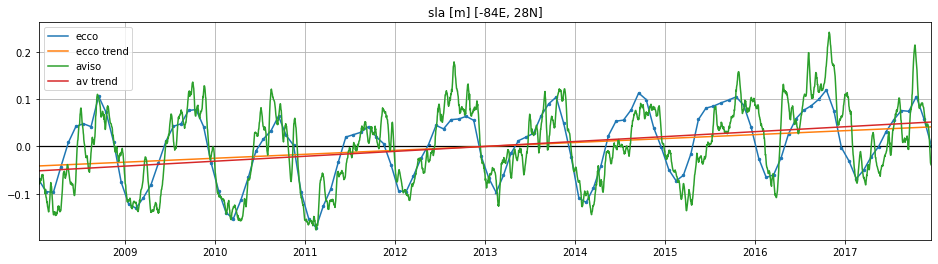

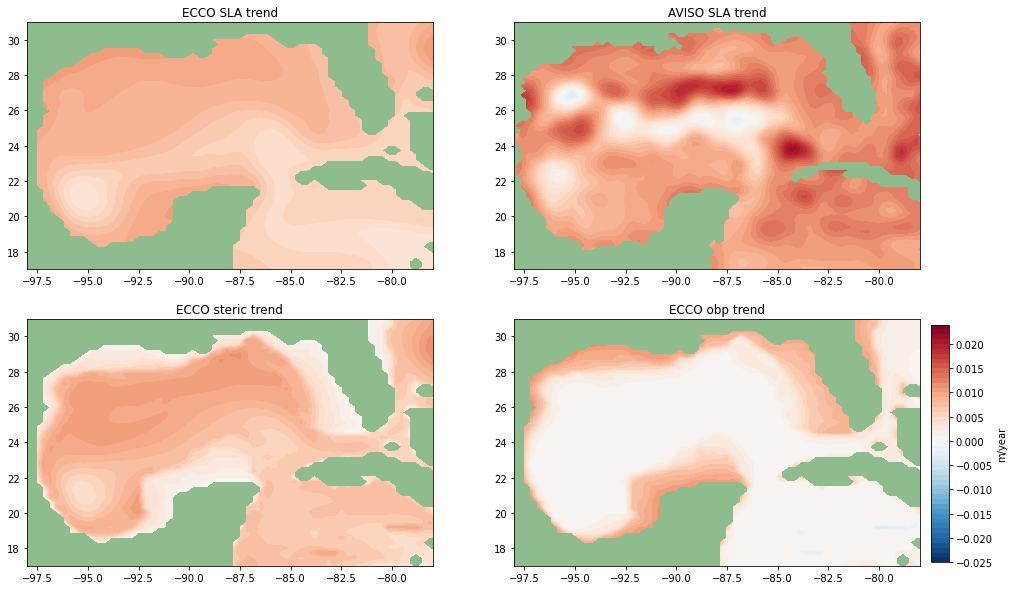

In [11]:
lon_range = [-100, -65] # [-128,-40]
lat_range = [15, 35] # [15, 50]
lon_range = [-98, -78] # [-128,-40]
lat_range = [17, 31] # [15, 50]
# pick one site to consider time series 
lon_site = -84; lat_site = 28; 
ecli = np.where((lons > lon_site-.65) & (lons < lon_site+.65) & (lats > lat_site-.65) & (lats < lat_site+.65))
eclon = lons[ecli[0][0], ecli[1][0]]; eclat = lats[ecli[0][0], ecli[1][0]]
# find aviso index to site selected above
avloni = np.where((av.longitude > eclon-.15) & (av.longitude < eclon+.15))[0][0]
avlati = np.where((av.latitude > eclat-.15) & (av.latitude < eclat+.15))[0][0]

f, ax = plt.subplots(1,1,figsize=(16,4))
ax.plot([ecco_monthly_ds.time[0].data,ecco_monthly_ds.time[-1].data], [0, 0], color='k', linewidth=1.25)
ax.plot(ecco_monthly_ds.time, ssh_anom[:,tile_num,ecli[0][0], ecli[1][0]], label='ecco')
ax.scatter(ecco_monthly_ds.time, ssh_anom[:,tile_num,ecli[0][0], ecli[1][0]], s=6)
# ax.plot(ecco_monthly_ds.time, obp[:,tile_num,ecli[0][0], ecli[1][0]], label='obp')
ax.plot(ecco_monthly_ds.time, ssh_a_trend[:,tile_num,ecli[0][0], ecli[1][0]], label='ecco trend')
ax.plot(av.time[av_time_o], avsla[:, avlati, avloni], label='aviso'); ax.plot(av.time[av_time_o], avsla_trend[:, avlati, avloni], label='av trend')
ax.set_title('sla [m] [' + str(lon_site) + 'E, ' + str(lat_site) + 'N]'); ax.legend(); ax.grid()
ax.set_xlim([ecco_monthly_ds.time[0].data,ecco_monthly_ds.time[-1].data])
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_02_24/GOM_sla_ecco_aviso_2011_2017.jpg', dpi=250)

f, ax = plt.subplots(2,2,figsize=(16,10)); clim = [-0.025, 0.025];
colMap = plt.get_cmap('RdBu_r'); # colMap.set_over(color='r');
pssh = pssh.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
print(pssh.polyfit_coefficients[0, tile_num, ecli[0][0], ecli[1][0]].data*1e9*60*60*24*365)
ax[0,0].contourf(lons,lats,pssh.polyfit_coefficients.isel(degree=0).isel(tile=tile_num)*1e9*60*60*24*365, \
            levels=np.arange(clim[0], clim[-1],0.001), vmin=clim[0],vmax=clim[-1], cmap=colMap); ax[0,0].set_facecolor('#8FBC8F')
# ax[0,0].scatter(lon_site,lat_site,s=10,color='g')
ax[0,0].set_title('ECCO SLA trend'); ax[0,0].set_xlim(lon_range); ax[0,0].set_ylim(lat_range); 
pobp = pobp.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
ax[1,1].contourf(lons,lats,pobp.polyfit_coefficients.isel(degree=0).isel(tile=tile_num)*1e9*60*60*24*365/g/rho0, \
            levels=np.arange(clim[0], clim[-1],0.001), vmin=clim[0],vmax=clim[-1], cmap=colMap); ax[0,1].set_facecolor('#8FBC8F')
# ax[1,1].scatter(lon_site,lat_site,s=10,color='g')
ax[1,1].set_title('ECCO obp trend'); ax[1,1].set_xlim(lon_range); ax[1,1].set_ylim(lat_range);
pster = pster.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
ax[1,0].contourf(lons,lats,pster.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365/g/rho0, \
            levels=np.arange(clim[0], clim[-1],0.001), vmin=clim[0],vmax=clim[-1], cmap=colMap); ax[1,0].set_facecolor('#8FBC8F') # .isel(tile=tile_num)
# ax[1,0].scatter(lon_site,lat_site,s=10,color='g')
ax[1,0].set_title('ECCO steric trend'); ax[1,0].set_xlim(lon_range); ax[1,0].set_ylim(lat_range)
Kc = ax[0,1].contourf(av.longitude,av.latitude,pavsla.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365, \
            levels=np.arange(clim[0], clim[-1], 0.001), vmin=clim[0],vmax=clim[-1], cmap=colMap); ax[1,1].set_facecolor('#8FBC8F')
# ax[0,1].scatter(lon_site,lat_site,s=10,color='g')
ax[0,1].set_title('AVISO SLA trend'); ax[0,1].set_xlim(lon_range); ax[0,1].set_ylim(lat_range)
cbpos = [0.91, 0.13, 0.015, 0.33]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='m/year')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_03_17/GOM_trends_2008_2018.jpg', dpi=250)

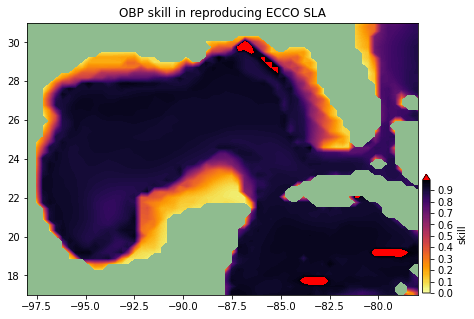

In [12]:
skill_ecco_sla_obp = np.nanvar(obp_anom.isel(tile=tile_num) - rho0*g*ssh_anom.isel(tile=tile_num), axis=0)/np.nanvar(rho0*g*ssh_anom.isel(tile=tile_num),axis=0)
f, ax = plt.subplots(1,1,figsize=(7,5));
colMap = plt.get_cmap('inferno_r'); colMap.set_over(color='r');
Kc = ax.contourf(lons,lats,skill_ecco_sla_obp,levels=np.arange(0, 1, 0.01), vmin=0, vmax=1,cmap=colMap, extend='max'); 
ax.set_facecolor('#8FBC8F')
ax.set_title('OBP skill in reproducing ECCO SLA'); 
ax.set_xlim(lon_range); ax.set_ylim(lat_range);
cbpos = [0.91, 0.13, 0.015, 0.33]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='skill')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_03_17/obp_skill_in_sla.jpg', dpi=250)

In [14]:
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
gulf_mask = xr.DataArray(
    data=ocean_mask.isel(tile=tile_num),
    dims=["j", "i"],
    coords=dict(
        i=(["i"], ecco_monthly_ds.XC.i.data), j=(["j"], ecco_monthly_ds.XC.j.data),
        XC=(["j","i"], ecco_monthly_ds.XC.isel(tile=tile_num).data), YC=(["j","i"], ecco_monthly_ds.YC.isel(tile=tile_num).data), 
    ),
)

In [15]:
# pos_test = np.where((lons > (this_lon-5)) & (lons < (this_lon+5)) & (lats > (this_lat-5)) & (lats < (this_lat+5)))
# lon_sub = pos_test[0]; lat_sub = pos_test[1];
lon_w = -98; lon_e = -80; 
lat_s = 17; lat_n = 31; 
gulf_mask = gulf_mask.where(lons > lon_w, np.nan)
gulf_mask = gulf_mask.where(lons < lon_e, np.nan)
gulf_mask = gulf_mask.where(lats > lat_s, np.nan)
gulf_mask = gulf_mask.where(lats < lat_n, np.nan)
# subdivisions 
sub1 = np.where((lons > -81.75) & (lats > 25))
gulf_mask[np.arange(sub1[0][0],sub1[0][-1]), np.arange(sub1[1][0],sub1[1][-1])] = np.nan
gulf_mask = gulf_mask.where(lons < -81, np.nan)
sub2 = np.where((lons > -88) & (lats < 21.85))
gulf_mask[np.arange(sub2[0][0],sub2[0][-1]), np.arange(sub2[1][0],sub2[1][-1])] = np.nan
sub3 = np.where((lons > -84) & (lats < 23))
gulf_mask[np.arange(sub3[0][0],sub3[0][-1]), np.arange(sub3[1][0],sub3[1][-1])] = np.nan

(17.0, 31.0)

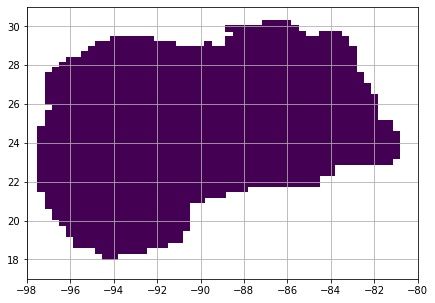

In [20]:
f, ax = plt.subplots(1,1,figsize=(7,5))
ax.pcolor(lons, lats, gulf_mask)
ax.grid(); ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])

In [21]:
lon_sub = np.where((lons > lon_range[0]) & (lons < lon_range[-1]))[0]; lat_sub = np.where((lats > lat_range[0]) & (lats < lat_range[-1]))[1]
fitloc = pobp.polyfit_coefficients.isel(degree=0).isel(tile=tile_num)*1e9*60*60*24*365/g/rho0
gulf_area = np.nansum(gulf_mask*ecco_monthly_ds.rA.isel(tile=tile_num))
mean_gulf_trend = np.nansum(fitloc*gulf_mask*ecco_monthly_ds.rA.isel(tile=tile_num))/gulf_area 
gulf_t_obp = fitloc*gulf_mask
gulf_a_obp = gulf_t_obp - mean_gulf_trend

In [241]:
lon_range[0]

-98

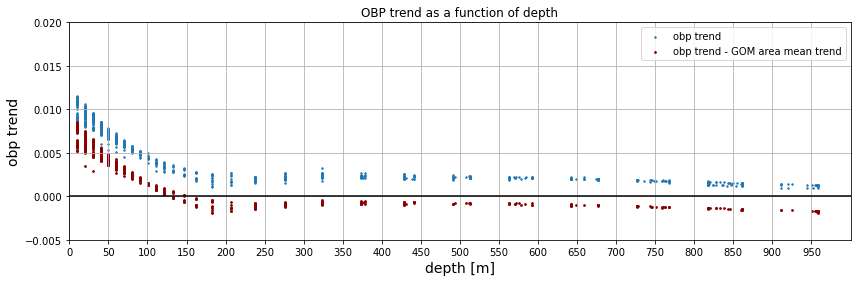

In [237]:
f, ax = plt.subplots(1,1,figsize=(14,4))
ax.plot([0,1500],[0, 0], color='k', linewidth=1.5)
ax.scatter(dep.isel(tile=tile_num).data[lon_sub[0]:lon_sub[-1],:][:,lat_sub[0]:lat_sub[-1]], \
           fitloc.data[lon_sub[0]:lon_sub[-1],:][:,lat_sub[0]:lat_sub[-1]], s=2, label='obp trend'); 
ax.scatter(dep.isel(tile=tile_num)*gulf_mask, gulf_a_obp, s=3, color='#8B0000', label='obp trend - GOM area mean trend'); 
ax.set_xlim([0,1000]); ax.set_ylim([-0.005,0.02]);
ax.set_xticks(np.arange(0,1000,50));
# ax.set_xticklabels(['0','25','50','75','100','125','150','175'])
ax.grid(); ax.set_xlabel('depth [m]', fontsize=14); ax.set_ylabel('obp trend', fontsize=14);
ax.set_title('OBP trend as a function of depth');
ax.legend()
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_02_24/GOM_obp_vs_dep.jpg', dpi=250)

Text(0.5, 1.0, 'OBP trend - GOM mean (0.0078 m/year)')

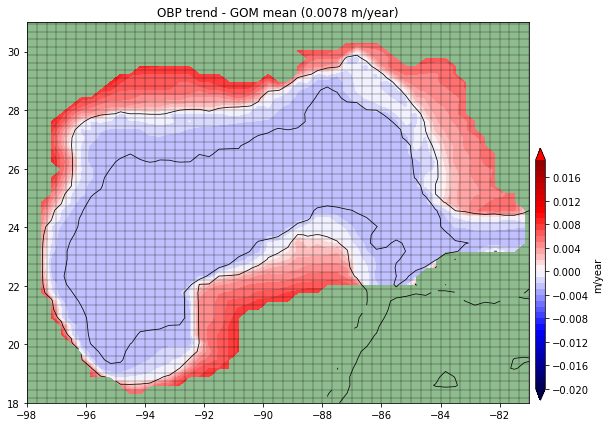

In [151]:
f, ax = plt.subplots(1,1,figsize=(9,7)); clim = [-0.02, 0.02];
colMap = plt.get_cmap('seismic'); colMap.set_over(color='r');
Kc = ax.contourf(lons,lats,gulf_a_obp, levels=np.arange(clim[0], clim[-1],0.001), \
            vmin=clim[0],vmax=clim[-1], cmap=colMap, extend='both'); 
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.3)
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.3)
ax.contour(lons, lats, dep.isel(tile=tile_num), [150], linewidths=0.75, colors='k')
ax.contour(lons, lats, dep.isel(tile=tile_num), [2000], linewidths=0.75, colors='k')
ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w,-81]); ax.set_ylim([18,lat_n]);
cbpos = [0.91, 0.13, 0.015, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='m/year')
ax.set_title('OBP trend - GOM mean (' + str(np.round(mean_gulf_trend,4)) + ' m/year)')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_03_17/GOM_obp_trend_anom.jpg', dpi=250)

In [26]:
gulf_rho_a = rho_a # - mean_gulf_rho_trend
rho_prime = gulf_rho_a[-1] - gulf_rho_a[0]

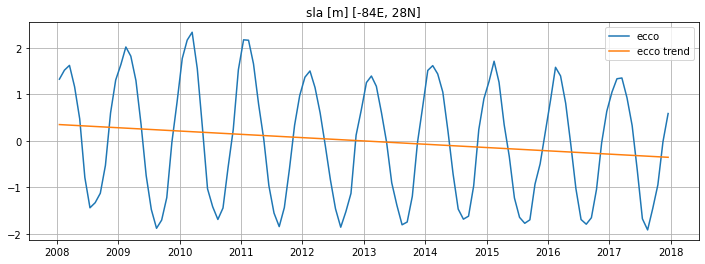

In [27]:
f, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(ecco_monthly_ds.time, rho_a[:,0,ecli[0][0], ecli[1][0]], label='ecco')
ax.plot(ecco_monthly_ds.time, rho_a_trend[:,0,ecli[0][0], ecli[1][0]], label='ecco trend')
ax.set_title('sla [m] [' + str(lon_site) + 'E, ' + str(lat_site) + 'N]'); ax.legend(); ax.grid()

In [28]:
h = dep.isel(tile=tile_num)
A = ecco_monthly_ds.rA.isel(tile=tile_num)*gulf_mask
As = gulf_area 
# imast = np.array([20,40,60,80,100,120,140,160,180,200,250,300,400,500,600,700,800,900])
imast = ecco_monthly_ds.drF.data.cumsum()[0:45]
AA = []
for i in range(len(imast)):
    AA.append(np.nansum(A.where(h <= imast[i], np.nan)))

print(imast)
print(100*(AA/gulf_area))
AAi = np.array([AA.copy()])
# AAi[1:] = np.diff(AAi)
AAi[0,0] = As
AAi[0,1:] = As - np.array([AA[0:-1]])
print(100*(AAi/gulf_area))
ii = imast
pbdeps = imast

[  10.         20.         30.         40.         50.         60.
   70.         80.01       90.04      100.15      110.47      121.270004
  133.03      146.45      162.48999   182.31      207.16      238.26001
  276.68      323.18      378.18      441.68      513.26      592.16003
  677.31006   767.49005   861.4501    958.0301   1056.28     1155.53
 1255.54     1356.87     1461.4299   1572.7599   1695.5898   1834.6798
 1993.6199   2174.45     2378.       2604.5      2854.       3126.5
 3422.       3740.5      4082.      ]
[  3.6398814   8.740954   13.355595   17.453392   21.270164   24.269274
  25.770435   27.06478    28.041124   28.638538   29.579464   30.452374
  31.000217   31.682638   31.682638   33.037727   33.569546   34.847973
  35.59864    36.40292    37.28815    38.171577   38.789513   39.674168
  40.687653   42.042305   43.41696    44.500793   46.096935   47.804825
  49.524807   50.869377   52.112644   53.638275   55.70773    57.631485
  59.433205   62.761784   65.1802     

In [225]:
imast[36]

1993.6199

In [216]:
iii = 27
print(imast[iii])
AAi[iii].data/(1000**2)

958.0301


857377.603584

In [226]:
vol_tot = np.sum(AAi[0:37].data*imast[0:37])
vol_1000 = np.sum(np.concatenate((AAi[27].data*np.ones(len(imast[0:27])), AAi[27:37].data))*imast[0:37])

In [227]:
vol_1000/vol_tot

0.9567509692957722

In [29]:
# AAi = xr.DataArray(data=np.tile(np.array(AAi)[:,None,None], (1,270,270)), dims=["layer","j", "i"],
#     coords=dict(
#         i=(["i"], ecco_monthly_ds.i.data), j=(["j"], ecco_monthly_ds.j.data),
#         XC=(["j","i"], ecco_monthly_ds.XC.isel(tile=tile_num).data), YC=(["j","i"], ecco_monthly_ds.YC.isel(tile=tile_num).data), 
#         layer=(["layer"], np.arange(0,len(pbdeps))),
#         ),
# )
AAi = xr.DataArray(data=AAi[0,:], dims=["layer"],
    coords=dict( 
        layer=(["layer"], np.arange(0,len(pbdeps))),
        ),
)

In [30]:
theta_a = ds_theta_r - ds_theta_r.mean(dim='time')

In [31]:
# -- density anomaly defined relative to local time mean 
rho_a = ds_den_r - ds_den_r.mean(dim='time')
p = rho_a.polyfit(dim='time', deg=1)
rho_a_trend = xr.polyval(rho_a['time'], p.polyfit_coefficients)
# -- density anomaly defined relative to rho0 
rho_a_rho0 = ds_den_r - rho0
p_rho0 = rho_a_rho0.polyfit(dim='time', deg=1)
rho_a_rho0_trend = xr.polyval(rho_a_rho0['time'], p_rho0.polyfit_coefficients)
# rho_gom_a = rho_a*gulf_mask
# rho_gom_a_mean = rho_gom_a.mean(dim=['j','i','time']) # mean profile 
# rho_gom_a = rho_gom_a # - rho_gom_a_mean
# prhoa = rho_gom_a.polyfit(dim='time', deg=1)
# rho_gom_a_trend = xr.polyval(rho_gom_a['time'], prhoa.polyfit_coefficients)

In [33]:
# -- Landerer Model -- 
# -- vertical grids and thickness 
v_cell_t = ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF
v_cell_t = v_cell_t.rename({'k': 'layer'})
v_cell_t = v_cell_t*gulf_mask
v_cell_z = np.cumsum(ecco_grid.drF.data)[0:45] # cumulative sum of layer depths 

# -- density anomaly from trend during time series duration (end-start)
# # mean_gulf_rho_trend = np.nansum(rho_a_trend*gulf_mask*ecco_monthly_ds.rA.isel(tile=tile_num))/gulf_area 
# gulf_rho_a_trend = rho_a_trend # rho_a_trend*gulf_mask - mean_gulf_rho_trend
# rho_prime = rho_gom_a_trend[-1] - rho_gom_a_trend[0] # density anomaly trend end - start 
# -- 
rho_prime = rho_a_trend[-1] - rho_a_trend[0]
rho_prime_2 = rho_a_rho0_trend[-1] - rho_a_rho0_trend[0]

delta_pb = np.nan*np.ones(len(pbdeps))
delta_pb_2 = np.nan*np.ones(len(pbdeps))
for m in range(0,45): # loop over all layers 
    this_i = np.where(v_cell_z <= ii[m])[0] # all depths shallower than depth i 
    this_i = this_i[-1] # deepest index (the layer we care about in this loop)
    
    below_i = np.arange(this_i+1,len(v_cell_z))
    above_i = np.arange(0,this_i+1)
    
    # -- for each layer, multiply rho_prime by layer thickness, then average across basin 
    below = (1/rho0)*( (AAi.isel(layer=below_i)/As)*\
                       (v_cell_t.isel(layer=below_i)*\
                       -1*rho_prime.isel(layer=below_i)).mean(dim=['j','i'])).sum(dim='layer')
    above = (1/rho0)*((As/AAi.isel(layer=above_i)-1)*(AAi.isel(layer=above_i)/As)*\
                       (v_cell_t.isel(layer=above_i)*\
                       -1*rho_prime.isel(layer=above_i)).mean(dim=['j','i'])).sum(dim='layer')
    delta_pb[m] = below.data - above.data
    # -- for each layer, multiply rho_prime by layer thickness, then average across basin 
    below = (1/rho0)*( (AAi.isel(layer=below_i)/As)*\
                       (v_cell_t.isel(layer=below_i)*\
                       -1*rho_prime_2.isel(layer=below_i)).mean(dim=['j','i'])).sum(dim='layer')
    above = (1/rho0)*((As/AAi.isel(layer=above_i)-1)*(AAi.isel(layer=above_i)/As)*\
                       (v_cell_t.isel(layer=above_i)*\
                       -1*rho_prime_2.isel(layer=above_i)).mean(dim=['j','i'])).sum(dim='layer')
    delta_pb_2[m] = below.data - above.data 

# -- imagine we only know things down to some depth 
depth_i = 29
print(v_cell_z[depth_i])
v_cell_z_upper = v_cell_z[0:depth_i] # depth coordinate cumsumed layer depth 
v_cell_t_upper = v_cell_t[0:depth_i] # thickness 
delta_pb_upper = np.nan*np.ones(len(pbdeps))
for m in range(0,len(v_cell_z_upper)): # loop over all layers 
    this_i = np.where(v_cell_z_upper <= v_cell_z_upper[m])[0] # all depths shallower than depth i 
    this_i = this_i[-1] # deepest index (the layer we care about in this loop)
    
    below_i = np.arange(this_i+1,len(v_cell_z_upper))
    above_i = np.arange(0,this_i+1)
    
    # -- for each layer, multiply rho_prime by layer thickness, then average across basin 
    below = (1/rho0)*( (AAi.isel(layer=below_i)/As)*\
                       (v_cell_t_upper.isel(layer=below_i)*\
                       -1*rho_prime.isel(layer=below_i)).mean(dim=['j','i'])).sum(dim='layer')
    above = (1/rho0)*((As/AAi.isel(layer=above_i)-1)*(AAi.isel(layer=above_i)/As)*\
                       (v_cell_t_upper.isel(layer=above_i)*\
                       -1*rho_prime.isel(layer=above_i)).mean(dim=['j','i'])).sum(dim='layer')
    delta_pb_upper[m] = below.data - above.data

1155.53


In [35]:
deltapbz = xr.DataArray(data=delta_pb, dims=["zi"],
                        coords=dict(zi=(["zi"], rho_prime.layer.data[0:len(pbdeps)]),),
                       )
deltapbz_2 = xr.DataArray(data=delta_pb_2, dims=["zi"],
                        coords=dict(zi=(["zi"], rho_prime.layer.data[0:len(pbdeps)]),),
                       )
deltapbz_upper = xr.DataArray(data=delta_pb_upper, dims=["zi"],
                        coords=dict(zi=(["zi"], rho_prime.layer.data[0:len(pbdeps)]),),
                       )

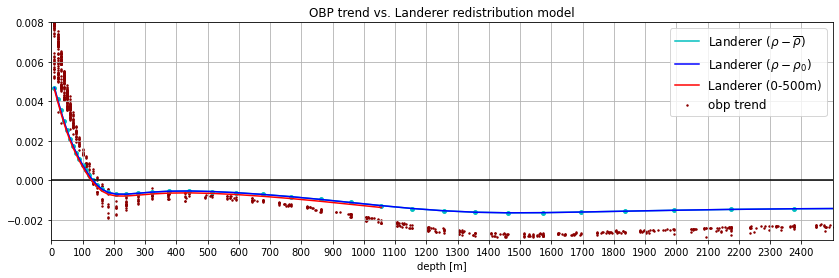

In [38]:
f,ax = plt.subplots(1,1,figsize=(14,4))
ax.plot([0,3000],[0, 0], color='k', linewidth=1.5)
ax.scatter(dep.isel(tile=tile_num)*gulf_mask, gulf_a_obp, s=2, color='#8B0000',label='obp trend'); 
ax.scatter(pbdeps, 1*deltapbz/10, color='c', s=15) # deltapbz.mean(dim=['j','i'])[0:len(pbdeps)]
ax.plot(pbdeps, 1*deltapbz/10, color='c', linewidth=1.5, label=r'Landerer ($\rho - \overline{\rho}$)')
ax.plot(pbdeps, 1*deltapbz_2/10, color='b', linewidth=1.5, label=r'Landerer ($\rho - \rho_0$)')
ax.plot(pbdeps, 1*deltapbz_upper/10, color='r', linewidth=1.5, label=r'Landerer (0-500m)')
ax.set_xlim([0,2500]); ax.set_ylim([-0.003,0.008]); 
ax.set_xticks(np.arange(0,2500,100));ax.set_xlabel('depth [m]')
ax.grid(); ax.set_title('OBP trend vs. Landerer redistribution model'); ax.legend(fontsize=12)
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_03_17/GOM_obp_landerer_2.jpg', dpi=250)

In [39]:
# -- map lander change back on to x,y locations 
landerer_xy = np.nan*np.ones(np.shape(gulf_a_obp))
for i in range(np.shape(gulf_a_obp)[0]):
    for j in range(np.shape(gulf_a_obp)[1]):
        this_dep = dep.isel(tile=tile_num)[j,i].data
        if ~np.isnan(this_dep):
            bot_ind = np.where(pbdeps <= this_dep)[0]
            if len(bot_ind >= 1):
                landerer_xy[j,i] = delta_pb[bot_ind[-1]]

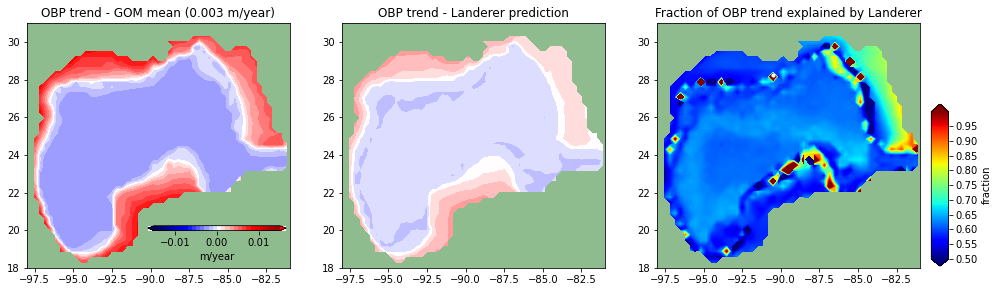

In [40]:
f, (ax,ax2,ax3) = plt.subplots(1,3,figsize=(16,4.5)); clim = [-0.015, 0.016];
colMap = plt.get_cmap('seismic'); colMap.set_over(color='r');
Kc0 = ax.contourf(lons,lats, gulf_a_obp, levels=np.arange(clim[0], clim[-1],0.001), \
            vmin=clim[0],vmax=clim[-1], cmap=colMap, extend='both'); 
ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w,-81]); ax.set_ylim([18,lat_n]);
Kc = ax2.contourf(lons,lats, gulf_a_obp - landerer_xy/10, levels=np.arange(clim[0], clim[-1],0.001), \
            vmin=clim[0],vmax=clim[-1], cmap=colMap, extend='both'); 
ax2.set_facecolor('#8FBC8F'); ax2.set_xlim([lon_w,-81]); ax2.set_ylim([18,lat_n]);

Kc = ax3.contourf(lons,lats, (landerer_xy/10)/gulf_a_obp, levels=np.arange(0.5,1,0.001), \
            vmin=0.5,vmax=1, cmap='jet', extend='both'); 
ax3.set_facecolor('#8FBC8F'); ax3.set_xlim([lon_w,-81]); ax3.set_ylim([18,lat_n]);

lon_site_i = -90.5; lat_site_i = 28.25
ecli = np.where((lons > lon_site_i-.65) & (lons < lon_site_i+.65) & (lats > lat_site_i-.65) & (lats < lat_site_i+.65))
ax3.scatter(lon_site_i,lat_site_i,s=10,color='w')

ax.set_title('OBP trend - GOM mean (' + str(np.round(mean_gulf_trend,4)) + ' m/year)')
ax2.set_title('OBP trend - Landerer prediction')
ax3.set_title('Fraction of OBP trend explained by Landerer')
cbpos = [0.91, 0.13, 0.015, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='fraction')
cbpos = [0.23, 0.24, 0.12, 0.015]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc0, cax=cax, orientation='horizontal', extend='both', label='m/year', ticks=[-0.01, 0, 0.01])
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_03_17/GOM_obp_landerer_diff.jpg', dpi=250)

In [41]:
# -- Landerer Model -- INPUT RHO RATHER THAN SOME RHO_PRIME 
v_cell_t = ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF
v_cell_t = v_cell_t.rename({'k': 'layer'})
v_cell_t = v_cell_t*gulf_mask
v_cell_z = np.cumsum(ecco_grid.drF.data)[0:45] # cumulative sum of layer depths 

delta_pb_total = np.nan*np.ones((np.shape(ds_den_r)[0],len(pbdeps)))
for tt in range(np.shape(ds_den_r)[0]):   # loop over all times 
    for m in range(0,45):                     # loop over all layers 
        this_i = np.where(v_cell_z <= ii[m])[0] # all depths shallower than depth i 
        this_i = this_i[-1] # deepest index (the layer we care about in this loop)
    
        below_i = np.arange(this_i+1,len(v_cell_z))
        above_i = np.arange(0,this_i+1)
    
        # -- for each layer, multiply rho_prime by layer thickness, then average across basin 
        below = (1/rho0)*( (AAi.isel(layer=below_i)/As)*\
                           (v_cell_t.isel(layer=below_i)*\
                           -1*ds_den_r[tt].isel(layer=below_i)).mean(dim=['j','i'])).sum(dim='layer')
        above = (1/rho0)*((As/AAi.isel(layer=above_i)-1)*(AAi.isel(layer=above_i)/As)*\
                           (v_cell_t.isel(layer=above_i)*\
                           -1*ds_den_r[tt].isel(layer=above_i)).mean(dim=['j','i'])).sum(dim='layer')
        delta_pb_total[tt,m] = below.data - above.data

depth_i = 29
v_cell_z_upper = v_cell_z[0:depth_i] # depth coordinate cumsumed layer depth 
v_cell_t_upper = v_cell_t[0:depth_i] # thickness 
delta_pb_total_upper = np.nan*np.ones((np.shape(ds_den_r)[0],len(pbdeps)))
for tt in range(np.shape(ds_den_r)[0]):   # loop over all times 
    for m in range(len(v_cell_z_upper)):                     # loop over all layers 
        this_i = np.where(v_cell_z_upper <= v_cell_z_upper[m])[0] # all depths shallower than depth i 
        this_i = this_i[-1] # deepest index (the layer we care about in this loop)
    
        below_i = np.arange(this_i+1,len(v_cell_z_upper))
        above_i = np.arange(0,this_i+1)
    
        # -- for each layer, multiply rho_prime by layer thickness, then average across basin 
        below = (1/rho0)*( (AAi.isel(layer=below_i)/As)*\
                           (v_cell_t_upper.isel(layer=below_i)*\
                           -1*ds_den_r[tt].isel(layer=below_i)).mean(dim=['j','i'])).sum(dim='layer')
        above = (1/rho0)*((As/AAi.isel(layer=above_i)-1)*(AAi.isel(layer=above_i)/As)*\
                           (v_cell_t_upper.isel(layer=above_i)*\
                           -1*ds_den_r[tt].isel(layer=above_i)).mean(dim=['j','i'])).sum(dim='layer')
        delta_pb_total_upper[tt,m] = below.data - above.data

In [127]:
deltapbz_total = xr.DataArray(data=np.transpose(delta_pb_total), dims=["zi","time"],
                        coords=dict(
                            zi=(["zi"], rho_prime.layer.data[0:len(pbdeps)]),
                            time=(["time"], ecco_monthly_ds.time.data),
                        ),
                       )
deltapbz_total_upper = xr.DataArray(data=np.transpose(delta_pb_total_upper), dims=["zi","time"],
                        coords=dict(
                            zi=(["zi"], rho_prime.layer.data[0:len(pbdeps)]),
                            time=(["time"], ecco_monthly_ds.time.data),
                        ),
                       )

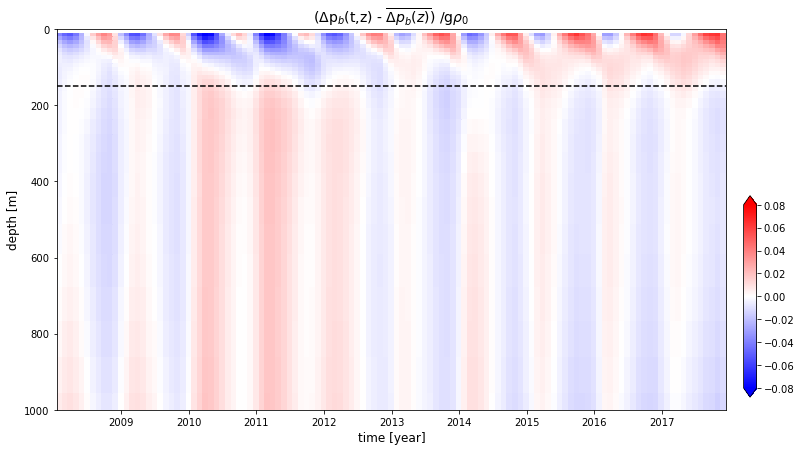

In [135]:
f, ax = plt.subplots(1,1,figsize=(12,7))
Kc=ax.pcolor(ecco_monthly_ds.time,pbdeps,deltapbz_total - deltapbz_total.mean(dim=['time']),cmap='bwr',vmin=-0.08,vmax=0.08)
ax.plot(ecco_monthly_ds.time,150*np.ones(len(ecco_monthly_ds.time)),color='k',linestyle='--')
ax.set_ylabel('depth [m]',fontsize=12); ax.set_xlabel('time [year]',fontsize=12); ax.set_ylim([0,1000]);
ax.set_title(r'($\Delta$p$_b$(t,z) - $\overline{\Delta p_b(z)}$) /g$\rho_0$',fontsize=14); ax.invert_yaxis()
cbpos = [0.92, 0.15, 0.015, 0.4]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both')
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_03_30/GOM_obp_landerer_in_time.jpg', dpi=250)

In [95]:
# -- obp
obpi = obp.isel(tile=tile_num)
depi = dep.isel(tile=tile_num)
delta_pb_obs = np.nan*np.ones((len(obpi.time), len(v_cell_z)))
for i in range(len(v_cell_z)):
    if i < 1:
        delta_pb_obs[:,i] = obpi.where(depi <= v_cell_z[i]).mean(dim=['j','i'])
    else:
        delta_pb_obs[:,i] = obpi.where((depi > v_cell_z[i-1]) & (depi <= v_cell_z[i]) ).mean(dim=['j','i'])

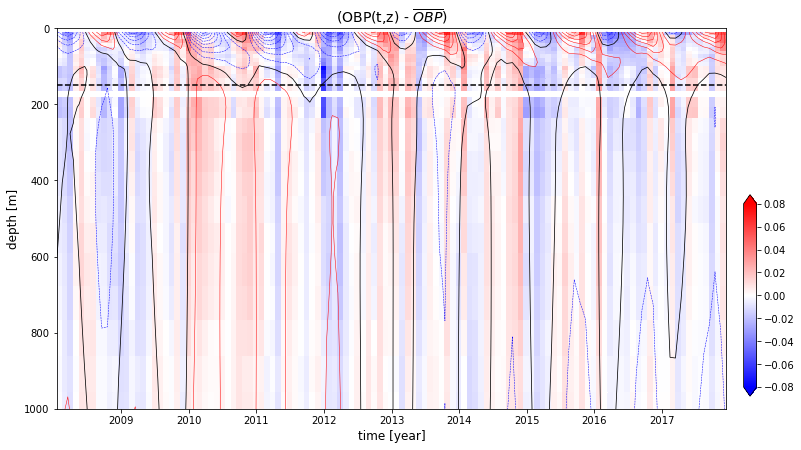

In [136]:
f, ax = plt.subplots(1,1,figsize=(12,7))
Kc=ax.pcolor(ecco_monthly_ds.time,v_cell_z,np.transpose(delta_pb_obs - np.nanmean(delta_pb_obs,axis=0))/g/rho0,cmap='bwr',vmin=-0.08,vmax=0.08)
ax.contour(ecco_monthly_ds.time, pbdeps, deltapbz_total - deltapbz_total.mean(dim=['time']),\
           levels=np.arange(-0.08,0,0.01),colors='b',linewidths=0.5)
ax.contour(ecco_monthly_ds.time,pbdeps, deltapbz_total - deltapbz_total.mean(dim=['time']),\
           levels=[0],colors='k',linewidths=0.75)
ax.contour(ecco_monthly_ds.time,pbdeps, deltapbz_total - deltapbz_total.mean(dim=['time']),\
           levels=np.arange(0.01,0.08,0.01),colors='r',linewidths=0.5)
ax.plot(ecco_monthly_ds.time,150*np.ones(len(ecco_monthly_ds.time)),color='k',linestyle='--')
ax.set_ylabel('depth [m]',fontsize=12); ax.set_xlabel('time [year]',fontsize=12); ax.set_ylim([0,1000]);
ax.set_title(r'(OBP(t,z) - $\overline{OBP}$)',fontsize=14); ax.invert_yaxis()
cbpos = [0.92, 0.15, 0.015, 0.4]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both')
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_03_30/GOM_obp_in_time.jpg', dpi=250)

In [137]:
# -- remove time mean from landerer predicted delta pb and fit linear trend at each depth 
test = (deltapbz_total - deltapbz_total.mean(dim=['time']))
p_test = test.polyfit(dim='time', deg=1)
p_test = (p_test.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365
test_upper = (deltapbz_total_upper - deltapbz_total_upper.mean(dim=['time']))
p_test_upper = test_upper.polyfit(dim='time', deg=1)
p_test_upper = (p_test_upper.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365

In [229]:
# -- consider linear trend of sla at each depth 
fitloc_sla = pssh.polyfit_coefficients.isel(degree=0).isel(tile=tile_num)*1e9*60*60*24*365
gulf_area = np.nansum(gulf_mask*ecco_monthly_ds.rA.isel(tile=tile_num))
mean_gulf_trend = np.nansum(fitloc*gulf_mask*ecco_monthly_ds.rA.isel(tile=tile_num))/gulf_area  # mean obp trend
gulf_t_sla = fitloc_sla*gulf_mask
gulf_a_sla = gulf_t_sla - mean_gulf_trend # remove basin avg. obp trend from sla trend 

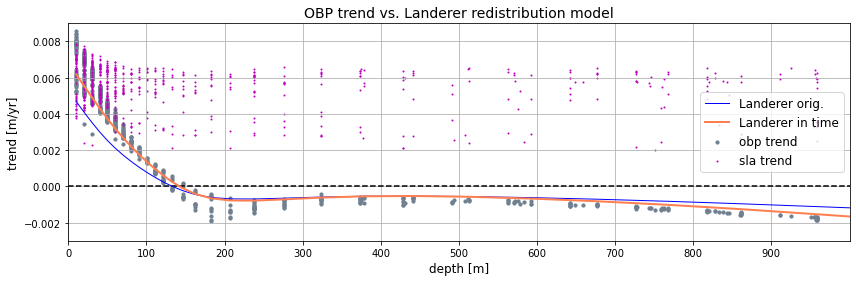

In [233]:
f,ax = plt.subplots(1,1,figsize=(14,4))
ax.plot([0,3000],[0, 0], color='k', linewidth=1.5, linestyle='--')
ax.scatter(dep.isel(tile=tile_num)*gulf_mask, gulf_a_obp, s=10, color='#708090',label='obp trend'); 
ax.scatter(dep.isel(tile=tile_num)*gulf_mask, gulf_a_sla, s=1, color='m',label='sla trend'); 
ax.plot(pbdeps, 1*deltapbz/10, color='b', linewidth=1, label='Landerer orig.') # divide here by the number of years of the time series 

ax.plot(pbdeps, p_test, color='#FF7F50', linewidth=2, label='Landerer in time')
# ax.plot(pbdeps, p_test_upper, color='#32CD32', linewidth=1.5, label='Landerer in time 0-' + str(np.int(v_cell_z[29])) + 'm')
ax.set_xlim([0,1000]); ax.set_xticks(np.arange(0,1000,100)); ax.set_xlabel('depth [m]',fontsize=12)
ax.set_ylim([-0.003, 0.009]); ax.set_ylabel('trend [m/yr]',fontsize=12)
ax.grid(); ax.set_title('OBP trend vs. Landerer redistribution model',fontsize=14); ax.legend(fontsize=12)
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_03_30/GOM_obp_landerer_w_sla.jpg', dpi=250)

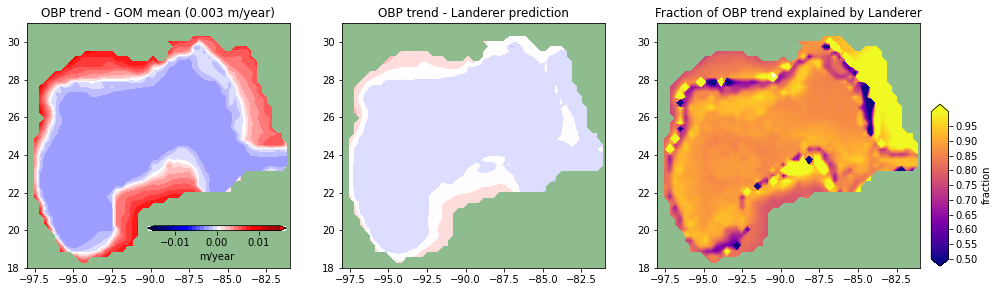

In [207]:
landerer_total_xy = np.nan*np.ones(np.shape(gulf_a_obp))
for i in range(np.shape(gulf_a_obp)[0]):
    for j in range(np.shape(gulf_a_obp)[1]):
        this_dep = dep.isel(tile=tile_num)[j,i].data
        if ~np.isnan(this_dep):
            bot_ind = np.where(pbdeps <= this_dep)[0]
            if len(bot_ind >= 1):
                landerer_total_xy[j,i] = p_test[bot_ind[-1]]

f, (ax,ax2,ax3) = plt.subplots(1,3,figsize=(16,4.5)); clim = [-0.015, 0.016];
colMap = plt.get_cmap('seismic'); colMap.set_over(color='r');
Kc0 = ax.contourf(lons,lats, gulf_a_obp, levels=np.arange(clim[0], clim[-1],0.001), \
            vmin=clim[0],vmax=clim[-1], cmap=colMap, extend='both'); 
ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w,-81]); ax.set_ylim([18,lat_n]);
Kc = ax2.contourf(lons,lats, gulf_a_obp - landerer_total_xy, levels=np.arange(clim[0], clim[-1],0.001), \
            vmin=clim[0],vmax=clim[-1], cmap=colMap, extend='both'); 
ax2.set_facecolor('#8FBC8F'); ax2.set_xlim([lon_w,-81]); ax2.set_ylim([18,lat_n]);

Kc = ax3.contourf(lons,lats, (landerer_total_xy)/gulf_a_obp, levels=np.arange(0.5,1,0.001), \
            vmin=0.5,vmax=1, cmap='plasma', extend='both'); 
ax3.set_facecolor('#8FBC8F'); ax3.set_xlim([lon_w,-81]); ax3.set_ylim([18,lat_n]);

lon_site_i = -90.5; lat_site_i = 28.25
ecli = np.where((lons > lon_site_i-.65) & (lons < lon_site_i+.65) & (lats > lat_site_i-.65) & (lats < lat_site_i+.65))
ax3.scatter(lon_site_i,lat_site_i,s=10,color='w')

ax.set_title('OBP trend - GOM mean (' + str(np.round(mean_gulf_trend,4)) + ' m/year)')
ax2.set_title('OBP trend - Landerer prediction')
ax3.set_title('Fraction of OBP trend explained by Landerer')
cbpos = [0.91, 0.13, 0.015, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='fraction')
cbpos = [0.23, 0.24, 0.12, 0.015]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc0, cax=cax, orientation='horizontal', extend='both', label='m/year', ticks=[-0.01, 0, 0.01])
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_03_17/GOM_obp_landerer_diff_in_time.jpg', dpi=250)

In [156]:
ds_den_argo = ds_den_r.where(dep.isel(tile=tile_num) > 1000)

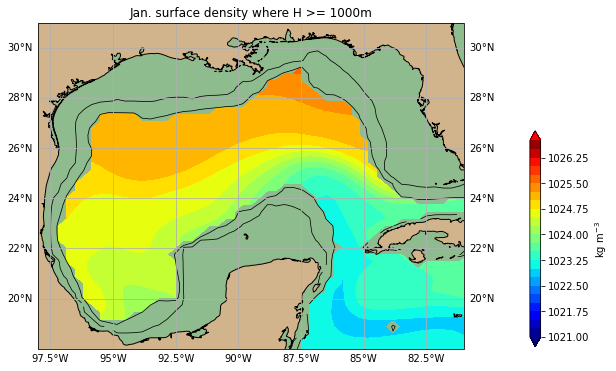

In [188]:
f1, ax = plt.subplots(1,1,figsize=(10,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
colMap = plt.get_cmap('jet'); colMap.set_over(color='r');
Kc = ax.contourf(lons, lats, ds_den_argo[0,0], levels=np.arange(1021, 1027, 0.25), cmap=colMap, extend='both',transform=ccrs.PlateCarree()); 
ax.contour(lons, lats, dep.isel(tile=tile_num), [150], linewidths=0.75, colors='k',transform=ccrs.PlateCarree())
ax.contour(lons, lats, dep.isel(tile=tile_num), [1000], linewidths=0.75, colors='k',transform=ccrs.PlateCarree())

ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False;
ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w,-81]); ax.set_ylim([18,lat_n]);

cbpos = [0.90, 0.13, 0.015, 0.5]; cax = f1.add_axes(cbpos); 
cb = f1.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='kg m$^{-3}$'); ax.set_title('Jan. surface density where H >= 1000m')
f1.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_03_30/GOM_1000m.jpg', dpi=250)

In [190]:
v_cell_z

array([  10.      ,   20.      ,   30.      ,   40.      ,   50.      ,
         60.      ,   70.      ,   80.01    ,   90.04    ,  100.15    ,
        110.47    ,  121.270004,  133.03    ,  146.45    ,  162.48999 ,
        182.31    ,  207.16    ,  238.26001 ,  276.68    ,  323.18    ,
        378.18    ,  441.68    ,  513.26    ,  592.16003 ,  677.31006 ,
        767.49005 ,  861.4501  ,  958.0301  , 1056.28    , 1155.53    ,
       1255.54    , 1356.87    , 1461.4299  , 1572.7599  , 1695.5898  ,
       1834.6798  , 1993.6199  , 2174.45    , 2378.      , 2604.5     ,
       2854.      , 3126.5     , 3422.      , 3740.5     , 4082.      ],
      dtype=float32)

In [177]:
# --- WHAT IF WE IGNORE ALL data in water less than 2000 m deep? 
depth_i = 37  # argo 0-2000
v_cell_z_upper = v_cell_z[0:depth_i] # depth coordinate cumsumed layer depth 
v_cell_t_upper = v_cell_t[0:depth_i] # thickness 
delta_pb_total_argo = np.nan*np.ones((np.shape(ds_den_r)[0],len(pbdeps)))
for tt in range(np.shape(ds_den_r)[0]):   # loop over all times 
    for m in range(len(v_cell_z_upper)):                     # loop over all layers 
        this_i = np.where(v_cell_z_upper <= v_cell_z_upper[m])[0] # all depths shallower than depth i 
        this_i = this_i[-1] # deepest index (the layer we care about in this loop)
    
        below_i = np.arange(this_i+1,len(v_cell_z_upper))
        above_i = np.arange(0,this_i+1)
    
        # -- for each layer, multiply rho_prime by layer thickness, then average across basin 
        below = (1/rho0)*( (AAi.isel(layer=below_i)/As)*\
                           (v_cell_t_upper.isel(layer=below_i)*\
                           -1*ds_den_argo[tt].isel(layer=below_i)).mean(dim=['j','i'])).sum(dim='layer')
        above = (1/rho0)*((As/AAi.isel(layer=above_i)-1)*(AAi.isel(layer=above_i)/As)*\
                           (v_cell_t_upper.isel(layer=above_i)*\
                           -1*ds_den_argo[tt].isel(layer=above_i)).mean(dim=['j','i'])).sum(dim='layer')
        delta_pb_total_argo[tt,m] = below.data - above.data

In [179]:
deltapbz_total_argo = xr.DataArray(data=np.transpose(delta_pb_total_argo), dims=["zi","time"],
                        coords=dict(
                            zi=(["zi"], rho_prime.layer.data[0:len(pbdeps)]),
                            time=(["time"], ecco_monthly_ds.time.data),
                        ),
                       )

In [184]:
# -- remove time mean from landerer predicted delta pb and fit linear trend at each depth 
test_argo = (deltapbz_total_argo - deltapbz_total_argo.mean(dim=['time']))
p_argo = test_argo.polyfit(dim='time', deg=1)
p_argo = (p_argo.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365

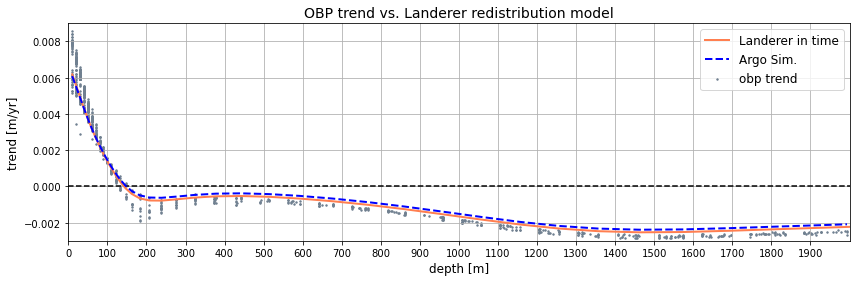

In [228]:
f,ax = plt.subplots(1,1,figsize=(14,4))
ax.plot([0,3000],[0, 0], color='k', linewidth=1.5, linestyle='--')
ax.scatter(dep.isel(tile=tile_num)*gulf_mask, gulf_a_obp, s=2, color='#708090',label='obp trend'); 
ax.plot(pbdeps, p_test, color='#FF7F50', linewidth=2, label='Landerer in time')
ax.plot(pbdeps, p_argo, color='b', linewidth=2, label='Argo Sim.', linestyle='--')

ax.set_xlim([0,2000]); ax.set_xticks(np.arange(0,2000,100)); ax.set_xlabel('depth [m]',fontsize=12)
ax.set_ylim([-0.003, 0.009]); ax.set_ylabel('trend [m/yr]',fontsize=12)
ax.grid(); ax.set_title('OBP trend vs. Landerer redistribution model',fontsize=14); ax.legend(fontsize=12)
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_03_30/GOM_obp_landerer_w_argo.jpg', dpi=250)

In [196]:
# --- DENSITY ANOMALY EXPLORATION --- 
# v_cell_t[:,ecli[0][0]-10,ecli[1][0]]
# rho_prime[:,ecli[0][0]-10,ecli[1][0]]
lon_site_0 = -84.5; lat_site_0 = 28; 
lon_site_1 = -84.5; lat_site_1 = 26; 
lon_site_2 = -94; lat_site_2 = 24; 
lon_site_3 = -92; lat_site_3 = 26.5; 

f1, ax = plt.subplots(1,1,figsize=(7,5)); clim = [-3.5, 3.5];
colMap = plt.get_cmap('seismic'); colMap.set_over(color='r');
Kc = ax.contourf(lons,lats,rho_a.isel(layer=0)[0], levels=np.arange(clim[0], clim[-1],0.01), \
            vmin=clim[0],vmax=clim[-1], cmap=colMap, extend='both'); 
ax.contour(lons, lats, dep.isel(tile=tile_num), [150, 152], linewidths=0.75, colors='k')
ax.scatter(lon_site_0,lat_site_0,s=10,color='g')
ax.scatter(lon_site_1,lat_site_1,s=10,color='g')
ax.scatter(lon_site_2,lat_site_2,s=10,color='g')
ax.scatter(lon_site_3,lat_site_3,s=10,color='g')
ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w,-81]); ax.set_ylim([18,lat_n]);
cbpos = [0.91, 0.13, 0.015, 0.5]; cax = f1.add_axes(cbpos); 
cb = f1.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='m/year'); ax.set_title('surface density anomaly')

# ---------------------
colMap = plt.get_cmap('RdBu');
f, ax = plt.subplots(2,2,figsize=(13,7))
ecli = np.where((lons > lon_site_0-.65) & (lons < lon_site_0+.65) & (lats > lat_site_0-.65) & (lats < lat_site_0+.65))
ax[0,0].pcolor(ecco_monthly_ds.time.data,np.cumsum(v_cell_t[:,ecli[0][0],ecli[1][0]].data), \
          np.transpose(theta_a[:,:,ecli[0][0],ecli[1][0]].data), vmin=-2.5, vmax=2.5, cmap=colMap)
# ax.plot([ecco_monthly_ds.time[0].data,ecco_monthly_ds.time[-1].data], \
#         [np.nanmax(np.cumsum(v_cell_t[:,ecli[0][0],ecli[1][0]].data)), np.nanmax(np.cumsum(v_cell_t[:,ecli[0][0],ecli[1][0]].data))], color='w')
ax[0,0].invert_yaxis(); ax[0,0].set_ylabel('depth [m]'); 
ax[0,0].set_title(r'$\theta - \overline{\theta}$ [' + str(lon_site_0) + 'E, ' + str(lat_site_0) + 'N] (+/- 2.5 $^{\circ}$)') # kg/m$^3$
ax[0,0].set(xticklabels=[])
# -
ecli = np.where((lons > lon_site_1-.65) & (lons < lon_site_1+.65) & (lats > lat_site_1-.65) & (lats < lat_site_1+.65))
ax[0,1].pcolor(ecco_monthly_ds.time.data,np.cumsum(v_cell_t[:,ecli[0][0],ecli[1][0]].data), \
          np.transpose(theta_a[:,:,ecli[0][0],ecli[1][0]].data), vmin=-.4, vmax=.4, cmap=colMap)
ax[0,1].invert_yaxis(); ax[0,0].set_ylabel('depth [m]');
ax[0,1].set_title(r'$\theta - \overline{\theta}$ [' + str(lon_site_1) + 'E, ' + str(lat_site_1) + 'N] (+/- .4 $^{\circ}$)')
ax[0,1].set(xticklabels=[])
# -
ecli = np.where((lons > lon_site_2-.65) & (lons < lon_site_2+.65) & (lats > lat_site_2-.65) & (lats < lat_site_2+.65))
ax[1,0].pcolor(ecco_monthly_ds.time.data,np.cumsum(v_cell_t[:,ecli[0][0],ecli[1][0]].data), \
          np.transpose(theta_a[:,:,ecli[0][0],ecli[1][0]].data), vmin=-0.025, vmax=0.025, cmap=colMap)
ax[1,0].invert_yaxis(); ax[0,0].set_ylabel('depth [m]'); ax[1,0].set_xlabel('date'); 
ax[1,0].set_title(r'$\theta - \overline{\theta}$ [' + str(lon_site_2) + 'E, ' + str(lat_site_2) + 'N] (+/- .025 $^{\circ}$)')
# -
ecli = np.where((lons > lon_site_3-.65) & (lons < lon_site_3+.65) & (lats > lat_site_3-.65) & (lats < lat_site_3+.65))
ax[1,1].pcolor(ecco_monthly_ds.time.data,np.cumsum(v_cell_t[:,ecli[0][0],ecli[1][0]].data), \
          np.transpose(theta_a[:,:,ecli[0][0],ecli[1][0]].data), vmin=-0.25, vmax=0.25, cmap=colMap)
ax[1,1].invert_yaxis(); ax[0,0].set_ylabel('depth [m]'); ax[1,0].set_xlabel('date'); 
ax[1,1].set_title(r'$\theta - \overline{\theta}$ [' + str(lon_site_3) + 'E, ' + str(lat_site_3) + 'N] (+/- .25 $^{\circ}$)')

# f1.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_03_17/GOM_locs.jpg', dpi=250)
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_03_17/GOM_theta_a.jpg', dpi=250)

ecli_0 = np.where((lons > lon_site_0-.65) & (lons < lon_site_0+.65) & (lats > lat_site_0-.65) & (lats < lat_site_0+.65))
ecli_1 = np.where((lons > lon_site_1-.65) & (lons < lon_site_1+.65) & (lats > lat_site_1-.65) & (lats < lat_site_1+.65))
ecli_2 = np.where((lons > lon_site_2-.65) & (lons < lon_site_2+.65) & (lats > lat_site_2-.65) & (lats < lat_site_2+.65))
ecli_3 = np.where((lons > lon_site_3-.65) & (lons < lon_site_3+.65) & (lats > lat_site_3-.65) & (lats < lat_site_3+.65))
f, ax = plt.subplots(2,2,figsize=(6,8),sharex=True)
for i in range(120):
    ax[0,0].plot(rho_a[i,:,ecli_0[0][0],ecli_0[1][0]].data, np.cumsum(v_cell_t[:,ecli_0[0][0],ecli_0[1][0]].data), color='k', linewidth=0.5)
    ax[0,1].plot(rho_a[i,:,ecli_1[0][0],ecli_1[1][0]].data, np.cumsum(v_cell_t[:,ecli_1[0][0],ecli_1[1][0]].data), color='k', linewidth=0.5)
    ax[1,0].plot(rho_a[i,:,ecli_2[0][0],ecli_2[1][0]].data, np.cumsum(v_cell_t[:,ecli_2[0][0],ecli_2[1][0]].data), color='k', linewidth=0.5)
    ax[1,1].plot(rho_a[i,:,ecli_3[0][0],ecli_3[1][0]].data, np.cumsum(v_cell_t[:,ecli_3[0][0],ecli_3[1][0]].data), color='k', linewidth=0.5)
ax[0,0].set_title(r'$\rho - \overline{\rho}$ [' + str(lon_site_0) + 'E, ' + str(lat_site_0) + 'N]')
ax[0,1].set_title(r'$\rho - \overline{\rho}$ [' + str(lon_site_1) + 'E, ' + str(lat_site_1) + 'N]')
ax[1,0].set_title(r'$\rho - \overline{\rho}$ [' + str(lon_site_2) + 'E, ' + str(lat_site_2) + 'N]')
ax[1,1].set_title(r'$\rho - \overline{\rho}$ [' + str(lon_site_3) + 'E, ' + str(lat_site_3) + 'N]')
ax[0,0].invert_yaxis(); ax[0,1].invert_yaxis(); ax[1,0].invert_yaxis(); ax[1,1].invert_yaxis(); 
ax[0,0].grid(); ax[0,1].grid(); ax[1,0].grid(); ax[1,1].grid(); 

5.686736111894406